- t-SNE를 활용하여 각 모델별 임베딩을 시각화함

- Word2Vec을 활용한 Genre Embedding의 경우 장르로 군집화 되는 뚜렷한 특징을 보여줌

- Causal Dilated Convolution Autoencoder을 활용한 Mel Embedding의 경우 군집화의 특성을 장르로 구별할 수 없음 (비슷한 멜로디라도 서로 다른 장르를 가지는 경우가 많음)

- CosineEmbeddingLoss Multimodal을 활용한 Genre, Mel Embedding의 경우 장르 임베딩의 특성과 멜 임베딩의 특성을 모두 가지고 있음

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings(action='ignore')

data_dir = '/content/drive/MyDrive/제 13회 투빅스 컨퍼런스 음악추천/Data/'

In [ ]:
%config InlineBackend.figure_format = 'retina'  # 레티나 디스플레이 지원을 통해 한글을 선명하게 보여줌
 
!apt -qq -y install fonts-nanum                 # 상기 라이브러리에 폰트 설치 
                                                # 이하 기본 폰트가 되도록 설정
# 한글 폰트를 사용할 수 있게 만들어줌
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=20)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


# 데이터 확인

In [ ]:
song_meta_df = pd.read_json(data_dir + 'song_meta_data_v3.json')
song_meta_df = song_meta_df.sort_values('id')
song_meta_df = song_meta_df.reset_index(drop = True)
song_meta_df['song_embedding_idx'] = song_meta_df.index

In [ ]:
playlist_df = pd.read_json(data_dir + 'playlist_data_v1.json')

In [ ]:
# 상위 약 5000개의 플레이리스트에 존재하는 노래만 시각화
playlist_cnt = 50
get_song_li_len = 0
while get_song_li_len <= 5000:
    new_playlist_df = playlist_df.sort_values('like_cnt', ascending = False)[:playlist_cnt]
    get_song_li = set()
    for i in new_playlist_df['songs'].tolist():
        get_song_li.update(i)
    get_song_li_len = len(get_song_li)
    print(playlist_cnt, get_song_li_len)
    playlist_cnt+= 1

50 5030


In [ ]:
new_song_meta_df = song_meta_df[song_meta_df['id'].apply(lambda x : True if str(x) in get_song_li else False)]
get_song_embedding_idx_li = new_song_meta_df['song_embedding_idx'].tolist()

In [ ]:
cos_embedding = np.load(data_dir + 'get_cos_embedding_63.npy')
cos_embedding = cos_embedding[get_song_embedding_idx_li]

mel_embedding = np.load(data_dir + 'tanh_mel_embeding_loss55.npy')
mel_embedding = mel_embedding[get_song_embedding_idx_li]

word2vec_embedding = np.load(data_dir + 'word2vec_embedding.npy')
word2vec_embedding = word2vec_embedding[get_song_embedding_idx_li]

In [ ]:
cos_embedding.shape

(5030, 128)

In [ ]:
mel_embedding.shape

(5030, 128)

In [ ]:
word2vec_embedding.shape

(5030, 128)

# 시각화 함수 정의

In [ ]:
from sklearn.manifold import TSNE
# from MulticoreTSNE import MulticoreTSNE as TSNE
# from tsnecuda import TSNE
from sklearn.decomposition import PCA

def show_year(vector, song_data):

    tsne = TSNE(n_components=2, random_state = 22)
    new_vector = tsne.fit_transform(vector)

    # pca = PCA(n_components = 2 , random_state = 22)
    # new_vector = pca.fit_transform(vector)

    new_song_meta_df = pd.DataFrame()

    new_song_meta_df['X'] = new_vector[:, 0]
    new_song_meta_df['Y'] = new_vector[:, 1]
    new_song_meta_df['year'] = song_data['issue_date'] // 10000
    new_song_meta_df['kor_song_gn_gnr_basket'] = song_data['kor_song_gn_gnr_basket'].values

    fig, ax_li = plt.subplots(nrows = 2, ncols = 1, figsize = (10 , 20))

    # year 시각화
    year_df = new_song_meta_df[new_song_meta_df['year'] >= 1950].reset_index(drop = True)
    C = year_df['year'].values
    a = ax_li[0].scatter(year_df['X'].values, year_df['Y'].values, c=C ,cmap = plt.cm.RdYlGn)
    plt.colorbar(a, ax=ax_li[0])
    a.set_clim(C.min(), C.max())
    ax_li[0].set_xlabel("X")
    ax_li[0].set_ylabel("Y")

    # 장르 시각화
    genre_df = new_song_meta_df[new_song_meta_df['kor_song_gn_gnr_basket'].apply(lambda x : len(x)) == 1].reset_index(drop = True)
    genre_df['kor_song_gn_gnr_basket'] = genre_df['kor_song_gn_gnr_basket'].apply(lambda x : x[0])
    genre_li = genre_df['kor_song_gn_gnr_basket'].unique()

    for genre in genre_li:
        if genre in ['일렉트로니카', '재즈', '랩/힙합', 'R&B/Soul', 'POP', 'OST', '록/메탈', '발라드', '댄스', '인디음악']:
            new_genre_df = genre_df[genre_df['kor_song_gn_gnr_basket'] == genre]
            ax_li[1].scatter(new_genre_df['X'].values, new_genre_df['Y'].values, label = genre)
    ax_li[1].set_xlabel("X")
    ax_li[1].set_xlabel("Y")
    ax_li[1].legend()
    plt.show()

# 시각화

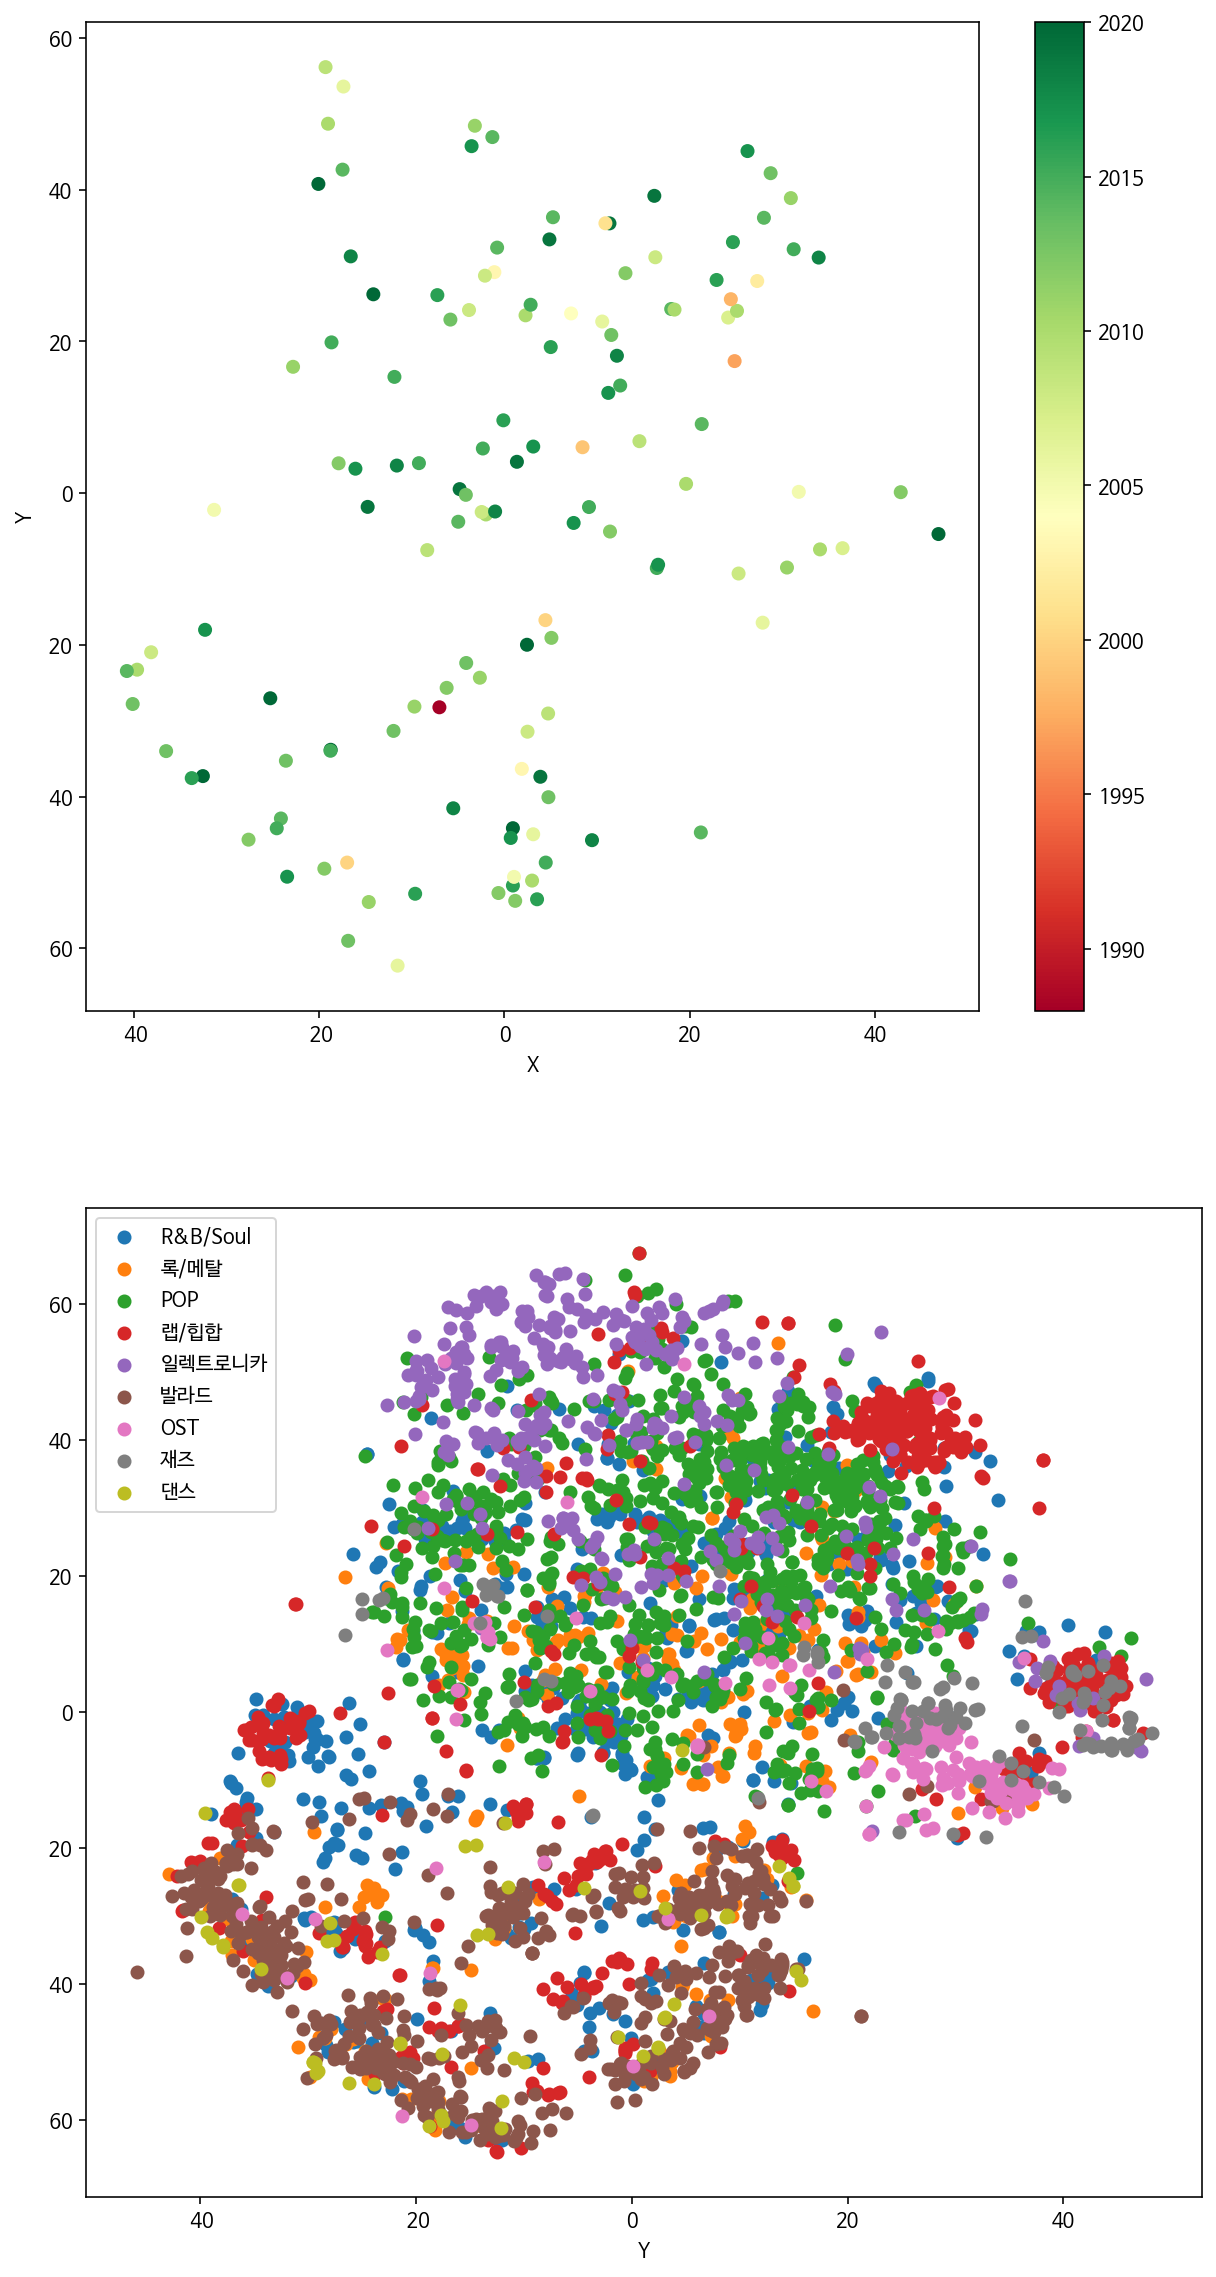

In [ ]:
show_year(vector = word2vec_embedding, song_data = new_song_meta_df)

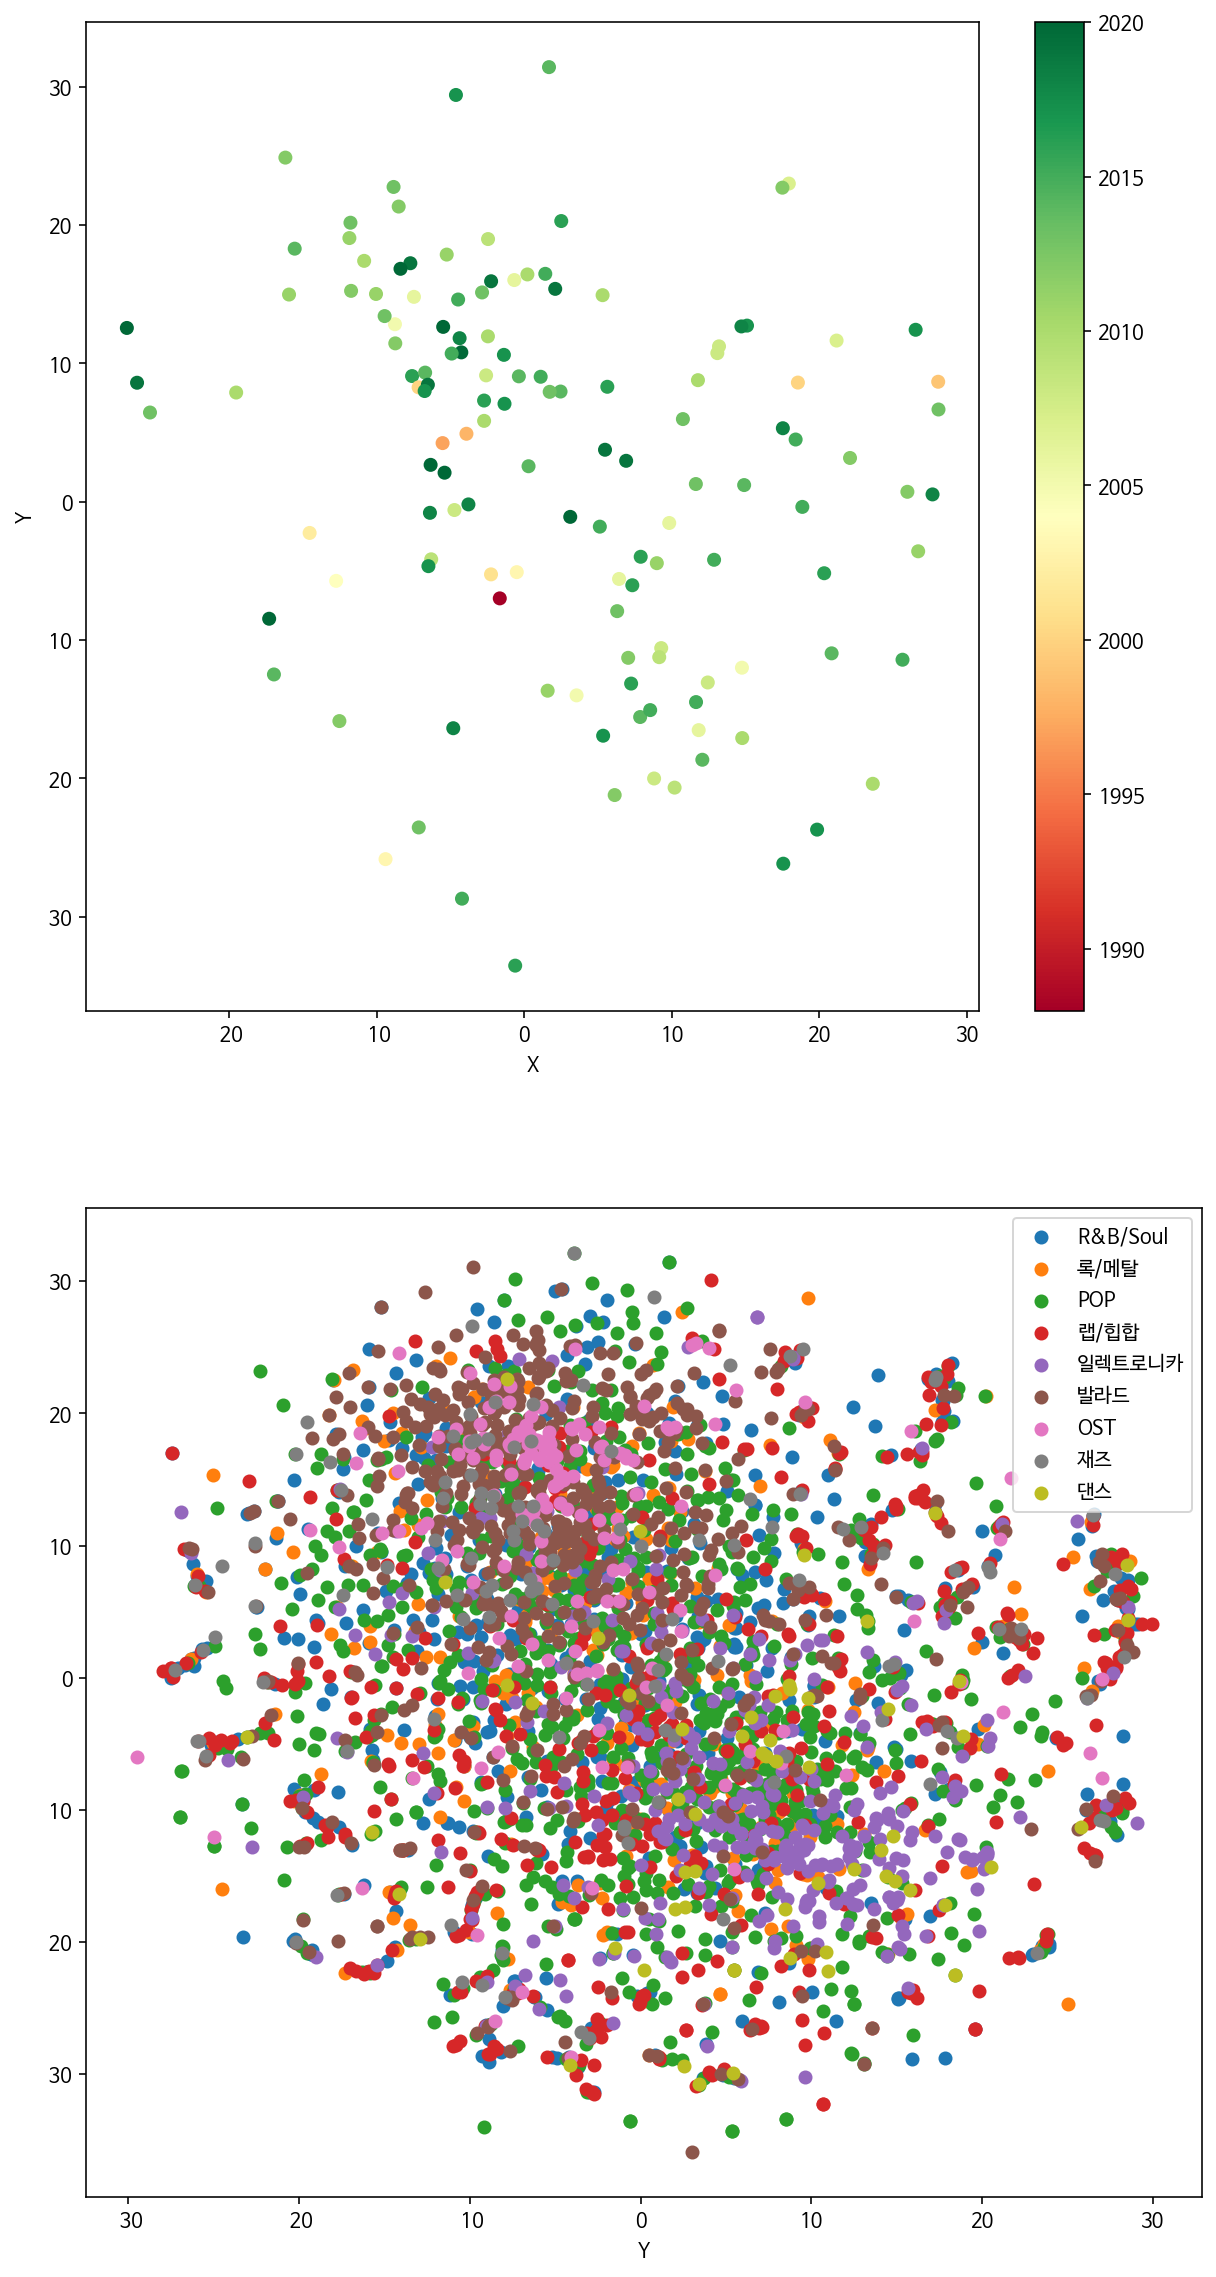

In [ ]:
show_year(vector = mel_embedding, song_data = new_song_meta_df)

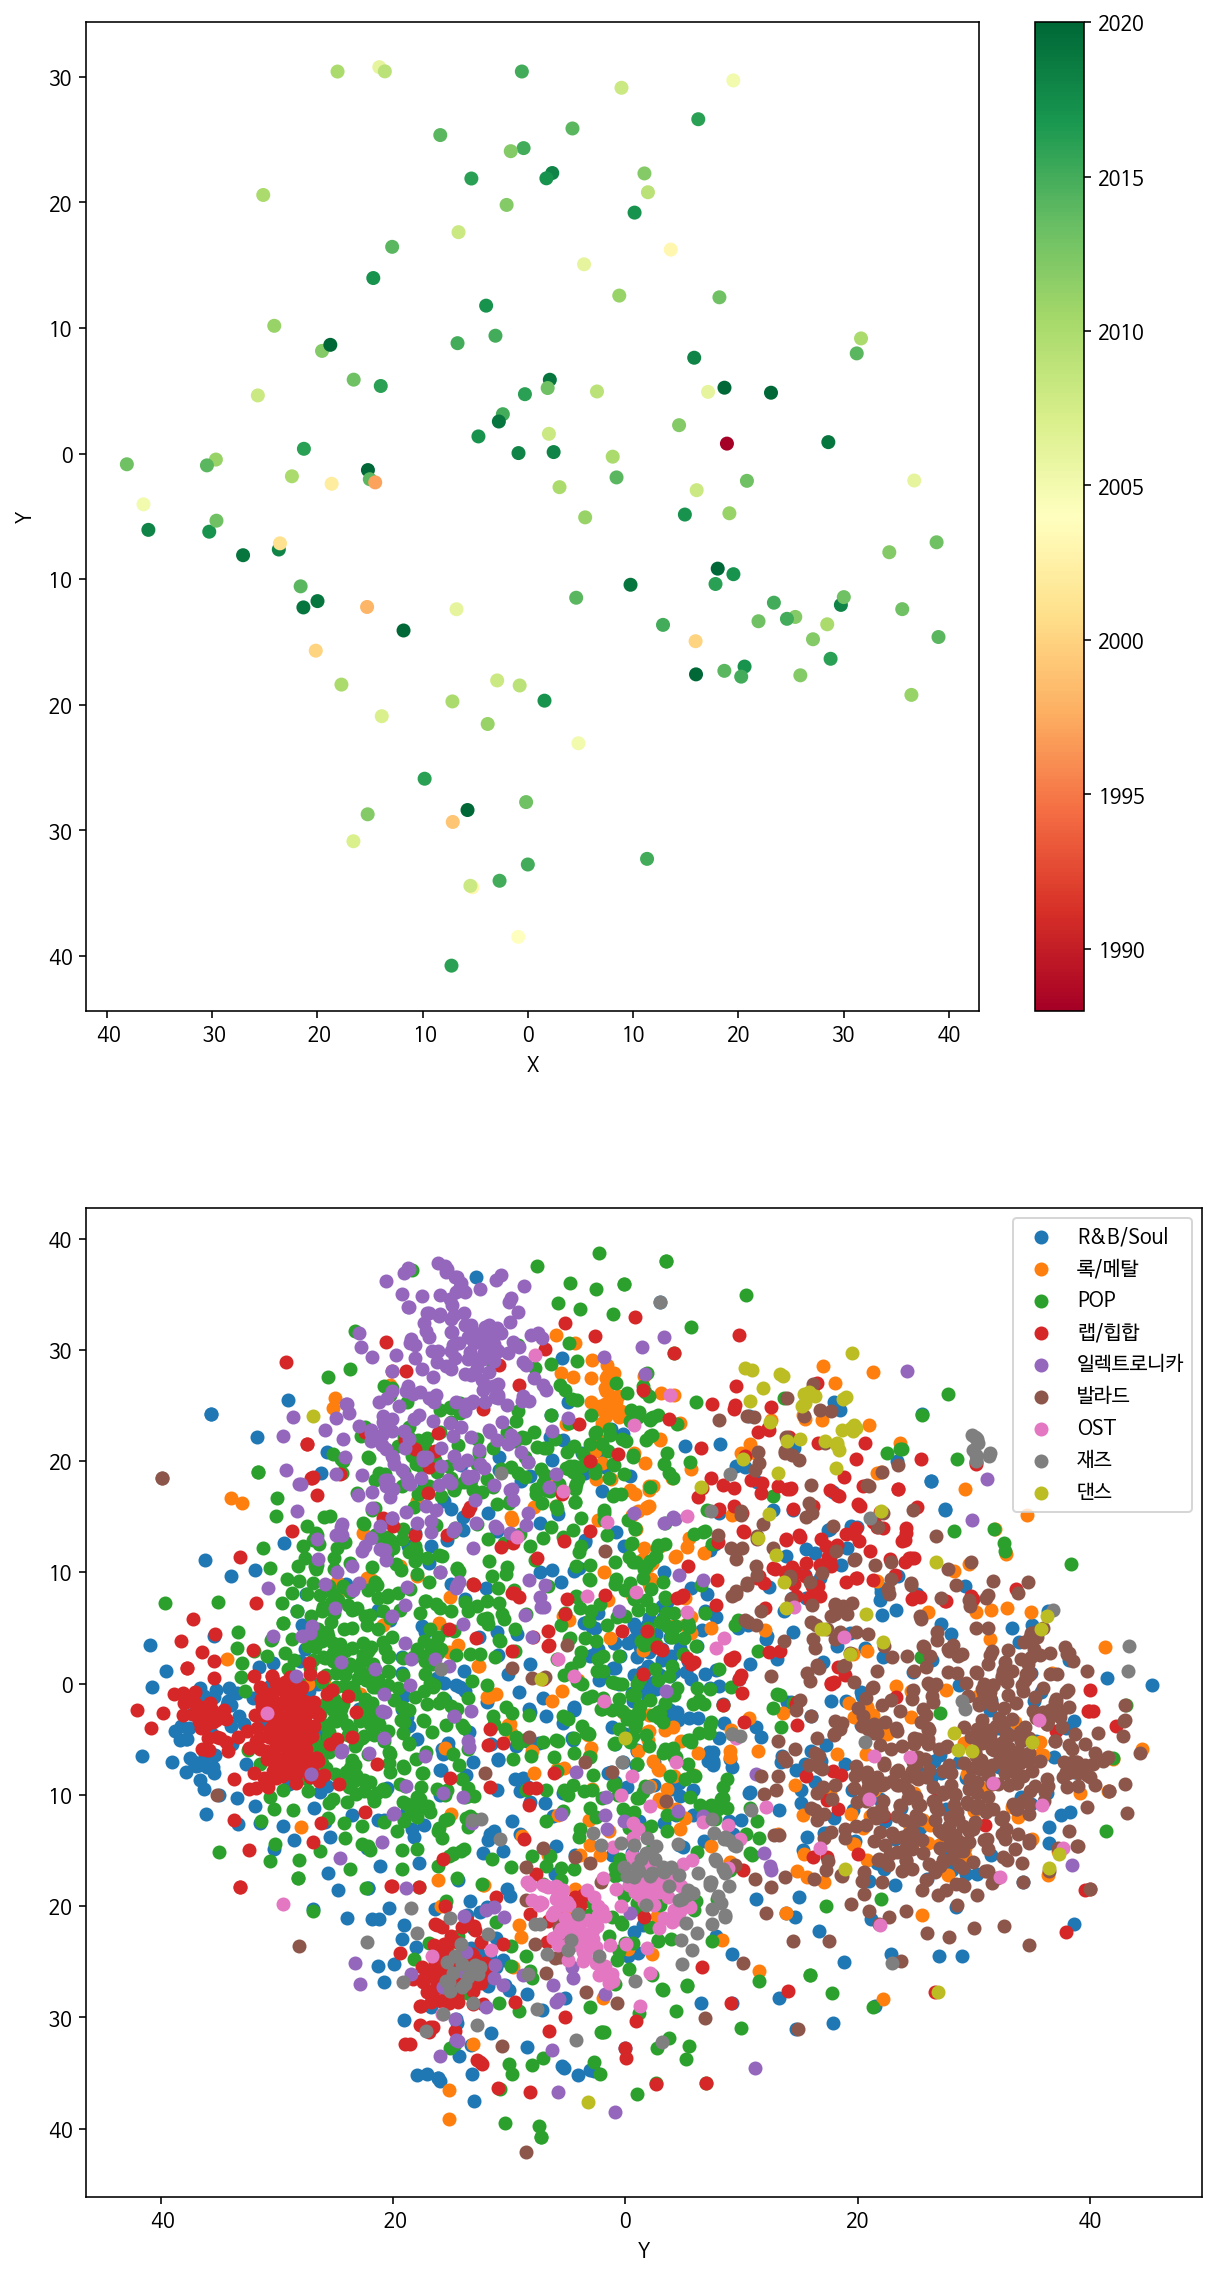

In [ ]:
show_year(vector = cos_embedding, song_data = new_song_meta_df)